In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
from langchain_community.document_loaders import ObsidianLoader

In [5]:
loader = ObsidianLoader("/Users/luisgg/Life itself")
docs = loader.load()

In [6]:
!pwd


/Users/luisgg/programacion/git/obsidian_agent/Obsidian_agent


In [7]:
print(f"Number of documents loaded: {len(docs)}")
print("\nFirst few documents preview:")
for i, doc in enumerate(docs[:3]):
    print(f"\nDocument {i+1}:")
    print(f"Source: {doc.metadata.get('source', 'No source')}")
    print(f"Content preview: {doc.page_content[:200]}...")

Number of documents loaded: 261

First few documents preview:

Document 1:
Source: Home 🛋️.md
Content preview: 
tags: [[Administración]]

[[Finanzas]]
[[Nutrición]]
- [[Lista de compras - mandado]]
- [[Ejercicio]]
- meal prep 
- desayuno, comida, cena

[[Goals]]
- comprarme una pc
- fashion
- dibujo

- [[Estud...

Document 2:
Source: Información.md
Content preview: ## [[Ingenieria 🦾]]

- [[Algoritmos de ordenamiento]]
- [[Big O notation]]
### [[Electronica - HW]]
- [[Conectar componentes]]

### [[Software engineering]]
- [[Docker en MacOS]]

#### [[ML]]
- [[Fuen...

Document 3:
Source: Administración.md
Content preview: ### Datos mios
[[Accounts]]
[[Codigos - seguridad _ Security codes]]
[[Codigo de fantastical calendar]]
[[Cuenta de megacable]]
[[Curriculum]]

### [[Finanzas]]
[[Fiesta de cumpleaños]]
[[Resources/Co...


# Parsing functions (no langchain, llm involved)

In [8]:
def parse_obsidian_note(doc):
    """Parse a single Obsidian note and extract its components"""
    import re
    from datetime import datetime
    
    content = doc.page_content
    source = doc.metadata.get('source', 'No source')
    
    # Define regex patterns
    date_pattern = r"(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2})"
    status_pattern = r"Status:\s*#(\w+)"
    tags_pattern = r"Tags:\s*((?:\[\[.*?\]\](?:\s|$))*)"
    wikilink_pattern = r"\[\[(.*?)\]\]"
    title_pattern = r"#\s+(.+)$"
    
    # Extract components from the header section
    header_lines = content.split('\n# ')[0].split('\n')
    
    # Extract date, status, and tags from header
    date_match = re.search(date_pattern, '\n'.join(header_lines))
    date = datetime.strptime(date_match.group(1), "%Y-%m-%d %H:%M") if date_match else None
    
    status_match = re.search(status_pattern, '\n'.join(header_lines))
    status = status_match.group(1) if status_match else None
    
    tags_match = re.search(tags_pattern, '\n'.join(header_lines))
    tags = []
    if tags_match:
        tags_section = tags_match.group(1)
        tags = re.findall(wikilink_pattern, tags_section)
    
    # Extract title and content
    parts = content.split('\n# ', 1)
    if len(parts) > 1:
        # Content has a title
        title_and_content = parts[1]
        title_parts = title_and_content.split('\n', 1)
        title = title_parts[0].strip()
        actual_content = title_parts[1].strip() if len(title_parts) > 1 else ""
    else:
        # No title found
        title = "Untitled"
        actual_content = content.strip()
    
    clean_source = source.replace('.md', '') if source.endswith('.md') else source
    
    return {
        "date": date,
        "status": status,
        "tags": tags,
        "title": title,
        "source_path": doc.metadata.get('source', ''),
        "content": actual_content,
        "source": clean_source
    }

In [9]:
# Test the parser with first document
first_doc = docs[25]
parsed = parse_obsidian_note(first_doc)

print("Parsed Note:")
print(f"Date: {parsed['date']}")
print(f"Status: {parsed['status']}")
print(f"Tags: {parsed['tags']}")
print(f"Title: {parsed['title']}")
print(f"Source: {parsed['source']}")

print(f"actual_content: {parsed['content']}")

Parsed Note:
Date: None
Status: None
Tags: []
Title: Untitled
Source: Temas selectos II
actual_content: ### Temas:
1. La view herramientas biomedica
2. Óptica biomedica
3. Oximetria
4. Interferometria

[[Clase 1 - Temas selectos II]]
[[Clase 5-03 - Temas selectos II]]
[[Clase 28-02 - Temas selectos II]]
[[Clase 4-03 Temas selectos II]]
[[Clase 6-03 - Temas selectos II]]
[[Aplicaciones de optica biomedica]]
[[Clase Temas 30-04. ]]


# Extraction chain

In [10]:
from typing import Optional, List
from pydantic import BaseModel, Field

class note_analysis(BaseModel):
    """Information about a note subject."""

    main_concept: Optional[List[str]] = Field(
        default=None, description="the main concept of the note in the taxonomy"
    )
    is_school_note: Optional[bool] = Field(
        default=None, description="if the note is a school note"
    )
    is_map_of_content: Optional[bool] = Field(
        default=None, description="if the note is a map of content(meaning it leads to other notes related to the overall concept)"
    )
    knowledge_type: Optional[str] = Field(
        default=None, description="type of knowledge (reference/action/project/resource/concept/map-of-content)"
    )
    created_date: Optional[str] = Field(
        default=None, description="creation date from the note if available"
    )
    status: Optional[str] = Field(
        default=None, description="status tag from the note"
    )
    content_tags: Optional[List[str]] = Field(
        default=None, description="relevant subject matter topics extracted from the note"
    )
    workflow_tags: Optional[List[str]] = Field(
        default=None, description="workflow-related tags (next-action, reference, project, etc.)"
    )
    temporal_tags: Optional[List[str]] = Field(
        default=None, description="time-relevant tags (today, daily, weekly, etc.)"
    )
    parent_notes: Optional[List[str]] = Field(
        default=None, description="higher-level notes this belongs under"
    )
    related_notes: Optional[List[str]] = Field(
        default=None, description="notes that are directly linked in the content"
    )
    tasks: Optional[List[str]] = Field(
        default=None, description="tasks or action items identified in the note"
    )
    review_frequency: Optional[str] = Field(
        default=None, description="how often to review (daily/weekly/monthly/quarterly/as-needed)"
    )

In [11]:
examples = [
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Implementing the Singleton Pattern in Django. Note Content: Tags: [[Singleton Pattern]] [[Python]] [[Django]] This note explores how to implement the Singleton design pattern in Python, specifically within a Django project. It covers the use of metaclasses and decorators to ensure that only one instance of a class is created. The note also discusses potential pitfalls and best practices when using the Singleton pattern in a web application context.",
        "answer": """
related_content_mentioned: ["Singleton Pattern", "Python", "Django"]
main_concept: ["TEC-PRO-PY", "TEC-PRO-SDP", "TEC-PRO-DJA"]
knowledge_type: "reference"
created_date: "None"
status: "None"
content_tags: ["Design Patterns", "Software Development", "Web Development"]
workflow_tags: ["reference", "implementation"]
temporal_tags: []
parent_notes: ["Software Architecture", "Python Development"]
related_notes: ["Design Patterns", "Django Best Practices"]
tasks: []
review_frequency: "as-needed"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Saving for a Down Payment. Note Content: Tags: [[Saving]] [[Investing]] [[Budgeting]] This note outlines my plan to save for a down payment on a house. It includes a detailed breakdown of my monthly budget, strategies for cutting expenses, and an analysis of potential investment options to accelerate savings. The goal is to reach the target within the next 5 years.",
        "answer": """
related_content_mentioned: ["Saving", "Investing", "Budgeting"]
main_concept: ["LIF-FIN-BUD", "LIF-FIN-INV", "LIF-GOA-LON"]
knowledge_type: "project"
created_date: "None"
status: "active"
content_tags: ["Personal Finance", "Housing", "Financial Planning"]
workflow_tags: ["goal", "tracking", "plan"]
temporal_tags: ["5-year"]
parent_notes: ["Financial Goals"]
related_notes: ["Monthly Budget", "Investment Strategy"]
tasks: ["Track monthly savings", "Research investment options", "Cut unnecessary expenses"]
review_frequency: "monthly"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Applying Atomic Habits to Daily Life. Note Content: Tags: [[Habit Formation]] [[Productivity]] [[Book Summary]] This note summarizes the key principles of the book \"Atomic Habits\" by James Clear. It explores how small changes in daily habits can lead to significant improvements over time. The note also provides practical tips for applying these principles to enhance productivity, achieve goals, and improve overall well-being.",
        "answer": """
related_content_mentioned: ["Habit Formation", "Productivity", "Book Summary"]
main_concept: ["PER-LEA", "PER-PRO", "LIF-ENT-BOO"]
knowledge_type: "reference"
created_date: "None"
status: "None"
content_tags: ["Self-Improvement", "Books", "Habit Building"]
workflow_tags: ["reference", "implementation"]
temporal_tags: ["daily"]
parent_notes: ["Personal Development"]
related_notes: ["Book Notes", "Productivity Systems"]
tasks: ["Implement habit stacking", "Create environment for good habits", "Track habit progress"]
review_frequency: "weekly"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Controlling an LED Matrix with Arduino. Note Content: Tags: [[Arduino]] [[Electronics]] [[LED Matrix]] This note documents my project of building and programming an LED matrix display using an Arduino microcontroller. It covers the wiring diagram, the code for controlling individual LEDs, and techniques for creating animations and displaying text.",
        "answer": """
related_content_mentioned: ["Arduino", "Electronics", "LED Matrix"]
main_concept: ["TEC-ELE-COM", "TEC-PRO"]
knowledge_type: "project"
created_date: "None"
status: "in-progress"
content_tags: ["Hardware", "Programming", "DIY"]
workflow_tags: ["project", "technical", "documentation"]
temporal_tags: []
parent_notes: ["Arduino Projects"]
related_notes: ["Arduino Programming", "Electronics Basics", "LED Projects"]
tasks: ["Finish wiring diagram", "Debug animation code", "Document final setup"]
review_frequency: "as-needed"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Deriving Backpropagation. Note Content: Tags: [[Backpropagation]] [[Neural Networks]] [[Calculus]] This note provides a detailed mathematical derivation of the backpropagation algorithm used for training artificial neural networks. It covers the chain rule of calculus and its application to calculating gradients for weight updates. The note also includes examples and visualizations to illustrate the concepts.",
        "answer": """
related_content_mentioned: ["Backpropagation", "Neural Networks", "Calculus"]
main_concept: ["TEC-ML-FOU", "TEC-MAT-CAL", "TEC-ML-ALG"]
knowledge_type: "reference"
created_date: "None"
status: "reference"
content_tags: ["Machine Learning", "Mathematics", "Algorithm"]
workflow_tags: ["reference", "technical"]
temporal_tags: []
parent_notes: ["Neural Networks", "Machine Learning Fundamentals"]
related_notes: ["Gradient Descent", "Chain Rule", "Forward Propagation"]
tasks: []
review_frequency: "quarterly"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Mastering Composition in Digital Painting. Note Content: Tags: [[Art]] [[Digital Painting]] [[Composition]] This note focuses on improving composition in digital painting. It covers various compositional techniques such as the rule of thirds, leading lines, and balancing elements. It also includes exercises and examples to help develop an eye for creating visually appealing artwork.",
        "answer": """
related_content_mentioned: ["Art", "Digital Painting", "Composition"]
main_concept: ["PER-ART-FUN"]
knowledge_type: "reference"
created_date: "None"
status: "resource"
content_tags: ["Digital Art", "Design", "Composition Rules"]
workflow_tags: ["learning", "resource", "practice"]
temporal_tags: []
parent_notes: ["Digital Art Skills"]
related_notes: ["Color Theory", "Perspective", "Art Fundamentals"]
tasks: ["Practice rule of thirds", "Study master compositions", "Create composition studies"]
review_frequency: "monthly"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: The Mediterranean Diet Plan. Note Content: Tags: [[Nutrition]] [[Diet]] [[Meal Planning]] This note explores the principles of the Mediterranean diet, emphasizing whole grains, fruits, vegetables, and healthy fats. It discusses the health benefits associated with this dietary pattern and provides a sample 7-day meal plan with recipes.",
        "answer": """
related_content_mentioned: ["Nutrition", "Diet", "Meal Planning"]
main_concept: ["LIF-HEA-NUT"]
knowledge_type: "action"
created_date: "None"
status: "active"
content_tags: ["Healthy Eating", "Meal Planning", "Recipes"]
workflow_tags: ["plan", "implementation", "routine"]
temporal_tags: ["weekly"]
parent_notes: ["Healthy Eating"]
related_notes: ["Meal Prep", "Grocery Lists", "Recipe Collection"]
tasks: ["Shop for Mediterranean ingredients", "Prepare weekly meal plan", "Track dietary changes"]
review_frequency: "weekly"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Qualitative vs. Quantitative Research. Note Content: Tags: [[Research Methods]] [[Social Sciences]] This note compares and contrasts qualitative and quantitative research methodologies commonly used in the social sciences. It examines the strengths and weaknesses of each approach, including data collection techniques, analysis methods, and typical applications. The note also discusses mixed-methods research as a way to combine the benefits of both approaches.",
        "answer": """
related_content_mentioned: ["Research Methods", "Social Sciences"]
main_concept: ["PER-INF-RES-MET"]
knowledge_type: "reference"
created_date: "None"
status: "reference"
content_tags: ["Research", "Methodology", "Academic"]
workflow_tags: ["reference", "academic"]
temporal_tags: []
parent_notes: ["Research Methodology"]
related_notes: ["Data Collection", "Analysis Methods", "Mixed Methods"]
tasks: []
review_frequency: "as-needed"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: My Weekly Cleaning Schedule. Note Content: Tags: [[Cleaning]] [[Home Maintenance]] [[Organization]] This note outlines my weekly cleaning schedule, designed to maintain a tidy and hygienic home environment. It includes a checklist of tasks for each day of the week, along with tips for efficient cleaning and recommended cleaning products.",
        "answer": """
related_content_mentioned: ["Cleaning", "Home Maintenance", "Organization"]
main_concept: ["LIF-HOM-HYG", "LIF-HOM-RES"]
knowledge_type: "action"
created_date: "None"
status: "active"
content_tags: ["Household", "Routines", "Cleaning"]
workflow_tags: ["routine", "checklist", "schedule"]
temporal_tags: ["weekly", "daily"]
parent_notes: ["Home Management"]
related_notes: ["Cleaning Supplies", "Home Organization"]
tasks: ["Monday bathroom cleaning", "Tuesday dusting", "Wednesday vacuuming", "Thursday kitchen deep clean", "Friday laundry", "Weekend maintenance"]
review_frequency: "weekly"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Quick Sort Complexity Analysis. Note Content: Tags: [[Algorithms]] [[Sorting]] [[Big O Notation]] This note analyzes the time and space complexity of the Quick Sort algorithm. It covers the best-case, average-case, and worst-case scenarios, using Big O notation to express the algorithm's efficiency. The note also includes a comparison with other sorting algorithms like Merge Sort and Bubble Sort.",
        "answer": """
related_content_mentioned: ["Algorithms", "Sorting", "Big O Notation"]
main_concept: ["TEC-PRO-ENG-ALG-SOR", "TEC-PRO-ENG-ALG-BIG"]
knowledge_type: "reference"
created_date: "None"
status: "reference"
content_tags: ["Algorithms", "Computer Science", "Complexity Analysis"]
workflow_tags: ["reference", "technical"]
temporal_tags: []
parent_notes: ["Algorithms"]
related_notes: ["Sorting Algorithms", "Algorithm Complexity", "Merge Sort", "Bubble Sort"]
tasks: []
review_frequency: "as-needed"
is_school_note: false
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Derechos humanos - bioetica. Note Content: # creación de la ONU y derechos humanos ### Intro: Características: - Traducido en 360 idiomas - Son intrínsecos - Son universales - Son inalienables",
        "answer": """
related_content_mentioned: []
main_concept: []
knowledge_type: "reference"
created_date: "None"
status: "None"
content_tags: ["Human Rights", "United Nations", "Bioethics", "Ethics"]
workflow_tags: ["academic", "notes"]
temporal_tags: []
parent_notes: ["Bioethics"]
related_notes: []
tasks: ["Complete assigned reading", "Prepare for discussion"]
review_frequency: "before-exam"
is_school_note: true
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Administración. Note Content: ### Datos mios [[Accounts]] [[Codigos - seguridad _ Security codes]] [[Codigo de fantastical calendar]] [[Cuenta de megacable]] [[Curriculum]] ### [[Finanzas]] [[Fiesta de graduación]] [[Resources/Compras]] [[Trabajo 💼]] - [[Quick airs]] - [[Hubspot - OpenAI]] ### [[Ideas relevantes]] - [[Improving]] - [[Posibles proyectos]] ## [[Estudiar]] ### Tecnologias ## [[ML]] #### [[Leetcode]] [[Web dev]] [[Django]] [[Electronica - HW]] [[Game dev]] [[Generative AI]] [[Matematicas]] ### [[Libros]] ### [[Language learning]] - [[Japon]] ### [[Entretenimiento 🎢]] - [[Juegos]] - [[Musica]] - [[Peliculas]] - [[Screenshots de cosas interesantes]] - [[Series]]",
        "answer": """
related_content_mentioned: ["Accounts", "Codigos - seguridad _ Security codes", "Codigo de fantastical calendar", "Cuenta de megacable", "Curriculum", "Finanzas", "Fiesta de graduación", "Resources/Compras", "Trabajo 💼", "Quick airs", "Hubspot - OpenAI", "Ideas relevantes", "Improving", "Posibles proyectos", "Estudiar", "Tecnologias", "ML", "Leetcode", "Web dev", "Django", "Electronica - HW", "Game dev", "Generative AI", "Matematicas", "Libros", "Language learning", "Japon", "Entretenimiento 🎢", "Juegos", "Musica", "Peliculas", "Screenshots de cosas interesantes", "Series"]
main_concept: ["PER-INF-KM"]
knowledge_type: "map-of-content"
created_date: "None"
status: "None"
content_tags: ["Personal Administration", "Organization", "Life Management"]
workflow_tags: ["organization", "directory"]
temporal_tags: []
parent_notes: ["Home 🛋️"]
related_notes: ["Finanzas", "Estudiar", "Trabajo 💼", "Entretenimiento 🎢"]
tasks: []
review_frequency: "monthly"
is_school_note: false
is_map_of_content: true
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: HOME MOC CONTENT. Note Content: tags: [[Administración]] [[Finanzas]] [[Nutrición]] - [[Lista de compras - mandado]] - [[Ejercicio]] - meal prep - desayuno, comida, cena [[Goals]] - comprarme una pc - fashion - dibujo - [[Estudiar]] - [[Matematicas]] - [[ML]] - [[auto worker]] - Programacion - [[Learning Go lang]] - [[django portafolio]] - Medicina - [[Life manager]] - [[Japanese guide]] [[Entretenimiento 🎢]] - [[Musica]] - ver algo ([[Peliculas]], [[Mangas]]) - videos - [[Juegos]] Responsabķlidades - higiene del hogar - higiene personal - [[Servicio Social]] [[Ideas relevantes]] [[Libros]] [[Maxxing]]",
        "answer": """
related_content_mentioned: ["Administración", "Finanzas", "Nutrición", "Lista de compras - mandado", "Ejercicio", "Goals", "Estudiar", "Matematicas", "ML", "auto worker", "Learning Go lang", "django portafolio", "Medicina", "Life manager", "Japanese guide", "Entretenimiento 🎢", "Musica", "Peliculas", "Mangas", "Juegos", "Servicio Social", "Ideas relevantes", "Libros", "Maxxing"]
main_concept: ["PER-INF-KM", "LIF-GOA"]
knowledge_type: "map-of-content"
created_date: "None"
status: "None"
content_tags: ["Life Organization", "Dashboard", "Personal Hub"]
workflow_tags: ["dashboard", "organization", "hub"]
temporal_tags: []
parent_notes: []
related_notes: ["Administración", "Finanzas", "Nutrición", "Goals", "Estudiar", "Entretenimiento 🎢"]
tasks: ["Comprarme una pc", "Fashion", "Dibujo", "Higiene del hogar", "Higiene personal"]
review_frequency: "daily"
is_school_note: false
is_map_of_content: true
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Ojecion de conciencia. Note Content: Este es nuestro infografico: ![[Business Project Infographic.png | 300]] ### Intro: **Ojecion de conciencia** Derecho a negarse a algo que no parece ser eticamente correcto Para los analisis debe haber *Cursos de accion* Transfusion a alguien que su religion no le deja Extremo Intermedios Extremo hacer transfucion, medicar la hemodialisis, dejar que muera",
        "answer": """
related_content_mentioned: ["Business Project Infographic.png"]
main_concept: []
knowledge_type: "reference"
created_date: "None"
status: "None"
content_tags: ["Ethics", "Bioethics", "Medical Ethics", "Conscience Objection"]
workflow_tags: ["academic", "notes", "coursework"]
temporal_tags: []
parent_notes: ["Bioethics", "Medical Ethics"]
related_notes: []
tasks: ["Complete analysis of action courses"]
review_frequency: "before-exam"
is_school_note: true
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Craneotomo y mesas quirurgicas. Note Content: 2024-06-18 22:04 Status: #teen Tags: [[Biomedica 🔬]] # Craneotomo y mesas quirurgicas # Creaneotomo y mesas quirurgicas ### Intro: Un craneótomo es un instrumento quirúrgico especializado utilizado en neurocirugía para realizar craniotomías, que es el proceso de cortar un hueso del cráneo para acceder al cerebro...",
        "answer": """
related_content_mentioned: ["Biomedica 🔬"]
main_concept: ["TEC-ELE-COM"]
knowledge_type: "reference"
created_date: "2024-06-18 22:04"
status: "teen"
content_tags: ["Biomedical Engineering", "Surgical Instruments", "Neurosurgery", "Operating Tables"]
workflow_tags: ["reference", "academic", "notes"]
temporal_tags: []
parent_notes: ["Biomedica 🔬"]
related_notes: ["Neurosurgery", "Medical Equipment"]
tasks: ["Review for medical instruments exam"]
review_frequency: "before-exam"
is_school_note: true
is_map_of_content: false
"""
    },
    {
        "question": "Analyze this note and extract the relevant information: Note Title: Rutina de salud 🫀. Note Content: 2024-07-21 23:07 Status: #child Tags: [[Administración]] # Rutina de salud 🫀 [[everyday]] [[Goals]] ## Mental [[espiritualidad]] ## Física [[Nutrición]] [[Ejercicio]]",
        "answer": """
related_content_mentioned: ["Administración", "everyday", "Goals", "espiritualidad", "Nutrición", "Ejercicio"]
main_concept: ["LIF-HEA-EXE", "LIF-HEA-MEN", "LIF-HEA-NUT"]
knowledge_type: "action"
created_date: "2024-07-21 23:07"
status: "child"
content_tags: ["Health", "Wellness", "Self-Care", "Routine"]
workflow_tags: ["routine", "daily", "checklist"]
temporal_tags: ["daily", "everyday", "2024"]
parent_notes: ["Administración"]
related_notes: ["Goals", "Nutrición", "Ejercicio", "everyday"]
tasks: ["Practice meditation", "Follow nutrition plan", "Exercise regularly"]
review_frequency: "daily"
is_school_note: false
is_map_of_content: false
"""
    },
]

In [12]:
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate

# First, create the example prompt template
example_prompt = PromptTemplate.from_template("""
Input: {question}
Output: {answer}
""")

# Then create the taxonomy prompt template
taxonomy_template = """You are a document classifier and knowledge manager for an Obsidian vault. Given a note's title and content, analyze it thoroughly and provide structured metadata that will help organize and retrieve this information.

Return the analysis in the following structured format:

metadata:
  title: "[The note's title]"
  created_date: "[Date from the note if available]"
  status: "[Status tag from the note: #child, #Adult, #reference, #active, #moc, etc.]"
  
classification:
  primary_categories: ["1-3 most relevant categories from taxonomy"]
  knowledge_type: ["reference/action/project/resource/concept/map-of-content"]
  is_school_related: [true/false based on academic content]
  is_map_of_content: [true/false based on if it organizes multiple notes]
  
tags:
  content_tags: ["Relevant subject matter topics extracted from the note"]
  workflow_tags: ["next-action", "reference", "project", "tracking", "plan", "resource", etc.]
  temporal_tags: ["today", "daily", "weekly", "monthly", "quarterly", "2024", etc. if time-relevant]
  
relationships:
  parent_notes: ["Higher-level notes this belongs under"]
  related_notes: ["Notes that are directly linked in the content"]
  
action_items:
  tasks: ["Any tasks or action items identified in the note"]
  review_frequency: ["daily/weekly/monthly/quarterly/as-needed" based on note type]

Use the following taxonomy for primary_categories:
    - **Technical (TEC)**
        - Programming (TEC-PRO)
            - Languages (e.g., Python, JavaScript) (TEC-PRO-PY, TEC-PRO-JS)
            - Frameworks/Libraries (e.g., React, TensorFlow) (TEC-PRO-REA, TEC-PRO-TF)
            - Software Development Principles (e.g., Design Patterns, Agile) (TEC-PRO-SDP, TEC-PRO-AGL)
            - **Engineering Principles** (TEC-PRO-ENG)
                - **Algorithms** (TEC-PRO-ENG-ALG)
                    - **Sorting Algorithms** (TEC-PRO-ENG-ALG-SOR)
                    - **Big O Notation** (TEC-PRO-ENG-ALG-BIG)
        - Mathematics (TEC-MAT)
            - Pure Mathematics (e.g., Algebra, Calculus, Number Theory) (TEC-MAT-ALG, TEC-MAT-CAL, TEC-MAT-NUM)
            - Applied Mathematics (e.g., Statistics, Probability) (TEC-MAT-STA, TEC-MAT-PRO)
        - Machine Learning (TEC-ML)
            - Algorithms (e.g., Supervised, Unsupervised, Reinforcement) (TEC-ML-SUP, TEC-ML-UNS, TEC-ML-REI)
            - Applications (e.g., NLP, Computer Vision) (TEC-ML-NLP, TEC-ML-CV)
            - Tools & Technologies (e.g., PyTorch, Scikit-learn) (TEC-ML-PYT, TEC-ML-SCI)
            - **Foundations** (TEC-ML-FOU)
        - **Electronics** (TEC-ELE)
            - **Components & Connections** (TEC-ELE-COM)
        - **Software Engineering** (TEC-SOF)
            - **Practices** (TEC-SOF-PRA)
                - **Docker (macOS)** (TEC-SOF-PRA-DOC)
    - **Personal Development (PER)**
        - Learning & Cognition (PER-LEA)
            - Learning Strategies (e.g., Spaced Repetition, Active Recall) (PER-LEA-SPR, PER-LEA-ACR)
            - Cognitive Biases (PER-LEA-COG)
            - Memory Enhancement (PER-LEA-MEM)
        - Information Management (PER-INF)
            - Knowledge Management (PER-INF-KM)
            - Note-Taking (PER-INF-NOT)
            - Research & Synthesis (PER-INF-RES)
            - **Research Methodologies** (PER-INF-RES-MET)
        - Productivity & Time Management (PER-PRO)
            - Goal Setting (PER-PRO-GOA)
            - Time Blocking (PER-PRO-TIM)
            - Prioritization (PER-PRO-PRI)
        - **Artistic Development** (PER-ART)
            - **Fundamentals of Design** (PER-ART-FUN)
    - **Lifestyle (LIF)**
        - Health & Fitness (LIF-HEA)
            - Exercise & Training (LIF-HEA-EXE)
            - Nutrition & Diet (LIF-HEA-NUT)
            - Mental Wellbeing (LIF-HEA-MEN)
        - Finance (LIF-FIN)
            - Personal Budgeting (LIF-FIN-BUD)
            - Investing (LIF-FIN-INV)
            - Financial Planning (LIF-FIN-PLA)
        - Entertainment (LIF-ENT)
            - Books, Movies, Music (LIF-ENT-BOO, LIF-ENT-MOV, LIF-ENT-MUS)
            - Hobbies & Interests (LIF-ENT-HOB)
        - Personal Goals & Aspirations (LIF-GOA)
            - Short-Term Goals (LIF-GOA-SHO)
            - Long-Term Goals (LIF-GOA-LON)
            - Aspirations (LIF-GOA-ASP)
        - **Home & Personal Care** (LIF-HOM)
            - **Hygiene** (LIF-HOM-HYG)
            - **Responsibilities** (LIF-HOM-RES)
            
For knowledge_type, consider these categories:
    - reference: Contains primarily factual information or resources
    - action: Contains things that need to be done or tracked
    - project: Related to a specific project with defined outcomes
    - resource: Collection of tools, links, or external materials
    - concept: Explores ideas, theories, or abstract concepts
    - map-of-content: Organizes multiple notes or topics
"""

suffix = """
Now analyze this note:
Title: {title}
Content: {content}
"""

# Create the few-shot prompt template
few_shot_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=taxonomy_template,
    suffix=suffix,
    input_variables=["title", "content"]  # Removed 'examples' from here
)

# Test the prompt
print(
    few_shot_prompt.invoke({
        "title": "github", 
        "content": docs[125].page_content
    }).to_string()
)

You are a document classifier and knowledge manager for an Obsidian vault. Given a note's title and content, analyze it thoroughly and provide structured metadata that will help organize and retrieve this information.

Return the analysis in the following structured format:

metadata:
  title: "[The note's title]"
  created_date: "[Date from the note if available]"
  status: "[Status tag from the note: #child, #Adult, #reference, #active, #moc, etc.]"
  
classification:
  primary_categories: ["1-3 most relevant categories from taxonomy"]
  knowledge_type: ["reference/action/project/resource/concept/map-of-content"]
  is_school_related: [true/false based on academic content]
  is_map_of_content: [true/false based on if it organizes multiple notes]
  
tags:
  content_tags: ["Relevant subject matter topics extracted from the note"]
  workflow_tags: ["next-action", "reference", "project", "tracking", "plan", "resource", etc.]
  temporal_tags: ["today", "daily", "weekly", "monthly", "quarte

In [13]:
structured_llm = llm.with_structured_output(schema=note_analysis)

In [14]:
parsed_input = parse_obsidian_note(docs[125])
input = {"title": parsed_input['source'], "content": docs[125].page_content}
prompt = few_shot_prompt.invoke(input)
structured_llm.invoke(prompt)

note_analysis(main_concept=['PER-INF-KM'], is_school_note=True, is_map_of_content=True, knowledge_type='map-of-content', created_date='None', status='None', content_tags=['School Subjects', 'Curriculum', 'Education'], workflow_tags=['organization', 'academic'], temporal_tags=[], parent_notes=['Education'], related_notes=['9° Subjects', '8° Subjects'], tasks=[], review_frequency='as-needed')

In [15]:
def new_analyze_note(title, content):
    input = {"title": title, "content": content}
    prompt = few_shot_prompt.invoke(input)
    return structured_llm.invoke(prompt)

In [33]:
import os
import uuid
from datetime import datetime
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_community.vectorstores.utils import filter_complex_metadata


In [34]:
# Find the transform_note function
def transform_note(title, concepts, parsed):
    note_title = title
    clean_content = parsed['content']
    date = parsed['date']
    status = parsed['status']
    tags = parsed['tags']
    
    # Add safety checks for None values
    main_concepts = concepts.main_concept if concepts.main_concept else []  # Use empty list if None
    is_school_note = concepts.is_school_note
    is_map_of_content = concepts.is_map_of_content
    
    # Format today's date as last_modified in the correct format
    from datetime import datetime
    today = datetime.now().strftime("%d-%m-%Y-%H-%M")
    
    # Set default status if None
    if status is None:
        status = "adult" if not is_school_note else "teen"
    
    # Ensure status has the hashtag format
    if not status.startswith("#"):
        status = f"#{status}"

    note_content = f"""---
last_modified: {today}
status: {status}
tags: {' '.join(['School'] + main_concepts) if is_school_note else ' '.join(main_concepts)}
is_map_of_content: {is_map_of_content}
---

Direct-links: {' '.join([f'[[{tag}]]' for tag in tags])}
{clean_content}
"""

    vault_location ="/Users/luisgg/tryingAI"
    file_path = os.path.join(vault_location, f"{parsed['source_path']}")
    os.makedirs(vault_location, exist_ok=True)
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(note_content)

    return note_content

In [35]:
"/Users/luisgg/tryingAI"

'/Users/luisgg/tryingAI'

In [36]:
# Process a single note
test_doc = docs[188]
parsed = parse_obsidian_note(test_doc)
concepts = new_analyze_note(parsed['source'], test_doc.page_content)

print(parsed['source'])
print(concepts)

new_note = transform_note(parsed['source'], concepts, parsed)
print(new_note)

Screenshots de cosas interesantes
main_concept=['PER-INF-KM'] is_school_note=False is_map_of_content=False knowledge_type='reference' created_date='2024-07-09 21:54' status='child' content_tags=['Interesting Media', 'Screenshots', 'Administration'] workflow_tags=['reference', 'media'] temporal_tags=[] parent_notes=['Administración'] related_notes=[] tasks=[] review_frequency='as-needed'
---
last_modified: 10-03-2025-22-53
status: #child
tags: PER-INF-KM
is_map_of_content: False
---

Direct-links: [[Administración]] [[media]]
#### Spotify WTF?
![[Pasted image 20231212223710.png]]



In [37]:
from uuid import uuid4
from datetime import datetime
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_community.vectorstores.utils import filter_complex_metadata

vector_store = Chroma(
    collection_name="obsidian_jarvis",
    embedding_function=embeddings,
    persist_directory="./obsidian_jarvis_db",  # Where to save data locally, remove if not necessary
)

In [38]:
vector_store.reset_collection()

In [39]:
def add_to_vector_store(title, parsed, concepts, i):
    # Get note content directly from parsed dictionary
    note_content = parsed['content']
    doc_id = str(uuid4())
    
    # Create metadata and filter out complex values
    metadata = {
        "title": title,
        "last_modified": datetime.now().isoformat(),
        "tags": ", ".join(parsed['tags']), # Convert list to string
        "concepts": ", ".join(concepts.main_concept) if concepts.main_concept else "", # Convert list to string, handle empty list
        "id": i,
        "uuid": doc_id
    }
    

    
    # Create document first, then filter its metadata
    composed_doc = Document(page_content=note_content, metadata=metadata)
    filtered_doc = filter_complex_metadata([composed_doc])[0]
    
    vector_store.add_documents(documents=[filtered_doc], ids=[doc_id])

In [40]:
add_to_vector_store(parsed['source'], parsed, concepts, 0)

In [41]:
retriever = vector_store.as_retriever(
    search_type="similarity", search_kwargs={"k": 5}
)
retriever.invoke("hay algo sobre ML?")

Number of requested results 5 is greater than number of elements in index 1, updating n_results = 1


[Document(id='9ce842cf-a679-4b80-8365-374f4ca8c814', metadata={'concepts': 'PER-INF-KM', 'id': 0, 'last_modified': '2025-03-10T22:53:45.798109', 'tags': 'Administración, media', 'title': 'Screenshots de cosas interesantes', 'uuid': '9ce842cf-a679-4b80-8365-374f4ca8c814'}, page_content='#### Spotify WTF?\n![[Pasted image 20231212223710.png]]')]

In [42]:
vector_store.delete(ids=['afa5d507-d461-469a-9228-a6d634d26f40'])

Delete of nonexisting embedding ID: afa5d507-d461-469a-9228-a6d634d26f40
Delete of nonexisting embedding ID: afa5d507-d461-469a-9228-a6d634d26f40


In [ ]:
for i, doc in enumerate(docs):
    parsed = parse_obsidian_note(doc)
    concepts = new_analyze_note(parsed['source'], doc.page_content)
    transform_note(parsed['source'], concepts, parsed)
    add_to_vector_store(parsed['source'], parsed, concepts, i) 

# loading a vector store and making a query and a retriever

In [19]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="obsidian_jarvis",
    embedding_function=embeddings,
    persist_directory="./obsidian_jarvis_db",  # Where to save data locally, remove if not necessary
)

In [ ]:


results = vector_store.similarity_search_with_score(
    "what can you tell me about langchain?", k=3,
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")


In [ ]:
retriever = vector_store.as_retriever(
    search_type="similarity", search_kwargs={"k": 8}
)
retriever.invoke("do you have anything on prompts?")

[]

In [22]:
# Get all IDs from collection
all_ids = vector_store.get()["ids"]

In [25]:
!pip install uuid

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6502 sha256=1bcdc50dea8342da9581ae5f6b5aac0ce9b9e7d7b7c4b409d2b8acce4d55b10d
  Stored in directory: /Users/luisgg/Library/Caches/pip/wheels/e0/01/df/bd20df409bd81f8b99e6cd343c5f49731dc0a20eefefdafae0
Successfully built uuid

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
uuids = [str(uuid4()) for _ in range(len(docs))]

NameError: name 'uuid4' is not defined

In [27]:
vector_store.delete(ids=uuids[38])

NameError: name 'uuids' is not defined

# Crear modelo con context y hacerle una pregunta con el retrieve

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/Users/luisgg/programacion/git/obsidian_agent/Obsidian_agent/venv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [29]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [30]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

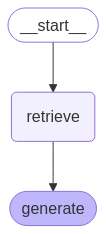

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "what can you tell me about tecnologies and projectes in the vault?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: []


Answer: I don't have information about specific technologies and projects in the vault.
